<a href="https://www.kaggle.com/code/aniruddhapa/cmi-lgbmclassifier-0-348?scriptVersionId=205624735" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

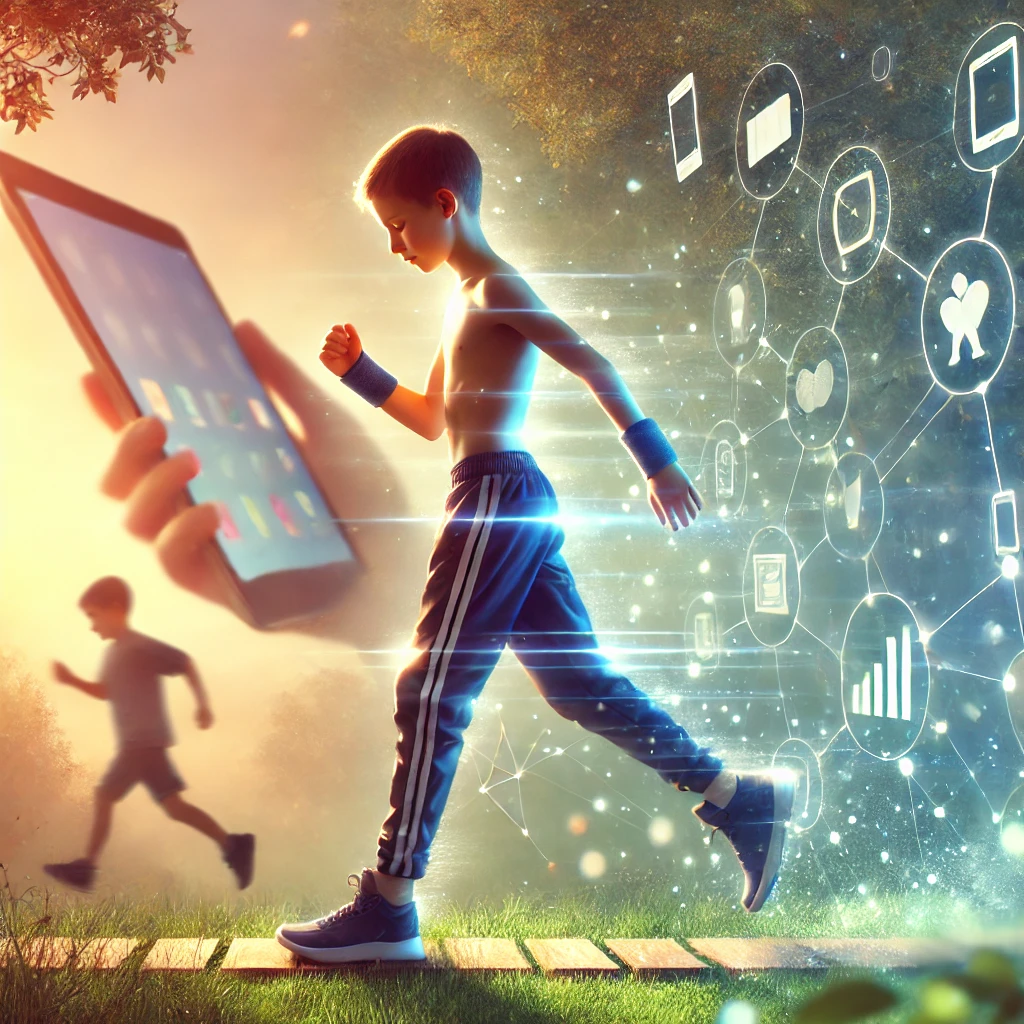

# Child Mind Institute — Problematic Internet Use

### Relating Physical Activity to Problematic Internet Use

---

## Overview
Can you predict the level of problematic internet usage exhibited by children and adolescents, based on their physical activity? The goal of this competition is to develop a predictive model that analyzes children's physical activity and fitness data to identify early signs of problematic internet use. Identifying these patterns can help trigger interventions to encourage healthier digital habits.

---

### Key Objectives
- **Predict PIU Levels**: Use physical activity data to assess the likelihood of children engaging in problematic internet use.
- **Early Intervention**: Enable early detection to encourage healthier digital habits and potentially reduce mental health issues like depression and anxiety, which are often associated with excessive internet use.
- **Accessible Data**: Physical activity metrics are easier to obtain than complex psychological assessments, making this approach more accessible to a wider po PIU level), following the structure below:



# Importing Libraries

# Import libraries
import optuna
import pandas as pd
import numpy as np
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from scipy.optimize import minimize
from statsmodels.stats.outliers_influence import variance_inflation_factor
      
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

SEED = 42

# Load the data

# Define the file paths
train_csv_path = '/kaggle/input/child-mind-institute-problematic-internet-use/train.csv'
test_csv_path = '/kaggle/input/child-mind-institute-problematic-internet-use/test.csv'
data_dictionary_path = '/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv'
actigraphy_train_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'
actigraphy_test_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet'

# Load the tabular data
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)
data_dictionary = pd.read_csv(data_dictionary_path)

data_dictionary.head()

train_data.head()

test_data.head()

# Function Definitions for Processing Time Series Data from Parquet Files

import os
# Custom functions
def process_file(filename, dirname):
    data = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    data.drop('step', axis=1, inplace=True)
    return data.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname):
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    data = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    data['id'] = indexes
    return data

# `load_time_series` Function Overview

The `load_time_series` function is designed to load multiple time-series files from a specified directory and process them in parallel, resulting in a summarized DataFrame. Below is a detailed breakdown of its functionality:


## 1. Retrieve All File/Folder Names

    * os.listdir(dirname) gets a list of all files or folders in the specified dirname directory and stores it in ids.

## 2. Process Files in Parallel:

    * ThreadPoolExecutor() is used to process the files concurrently. This parallel processing speeds up the function, especially if there are many files to process.

    * For each file/folder name in ids, it calls the process_file function using a lambda function, with fname as the filename and dirname as the directory.

    * tqdm() is used to display a progress bar, showing how many files have been processed out of the total (total=len(ids)).

## 3. Unpack the Results:

* results is a list where each entry contains:
    * The flattened summary statistics of each file (from process_file).
    * An identifier derived from the filename (also from process_file).

* zip(results) splits this list of tuples into two separate lists:
    * stats holds the summary statistics arrays for each file.
    * indexes holds the identifiers (extracted from the filename).

## 4. Create a DataFrame from Summary Statistics:

    * A DataFrame data is created with stats as rows, with each column named stat_0, stat_1, etc., based on the number of summary statistics.

    * data['id'] = indexes adds an id column with unique identifiers from each file.

## 5. Return the Summary DataFrame:

    * Finally, the function returns data, a DataFrame where each row represents a summarized time-series file with its unique identifier.

This function is efficient for summarizing large numbers of time-series files quickly and storing the summary information in a single, structured DataFrame.

train_parquet = load_time_series(actigraphy_train_path)
test_parquet = load_time_series(actigraphy_test_path)

# Merge and preprocess data
train_df = pd.merge(train_data, train_parquet, how="left", on='id')
test_df = pd.merge(test_data, test_parquet, how="left", on='id')

train_df.shape

test_df.shape

# Drop all columns starting with 'PCIAT-PCIAT' except 'PCIAT-PCIAT_Total'
columns_to_keep = ['PCIAT-PCIAT_Total']
columns_to_drop = [col for col in train_df.columns if col.startswith('PCIAT-PCIAT') and col != 'PCIAT-PCIAT_Total']

# Drop the columns
train_df = train_df.drop(columns=columns_to_drop)

print(f"Columns dropped: {columns_to_drop}")
print(f"Remaining columns: {train_df.columns}")


train_df.shape

# List of columns in the test dataset
test_columns = test_df.columns.tolist()

# List of columns in the train dataset 
train_columns = train_df.columns.tolist()

# Find columns that are in the train dataset but not in the test dataset
columns_only_in_train = list(set(train_columns) - set(test_columns))

# Find columns that are in the test dataset but not in the train dataset
columns_only_in_test = list(set(test_columns) - set(train_columns))

# Display the non-matching columns
print("Columns only in the train dataset:", columns_only_in_train)
print("Columns only in the test dataset:", columns_only_in_test)


**Dropping the 'PCIAT-PCIAT_Total', 'PCIAT-Season' columns, as we need to predict 'sii' which is derived from 'PCIAT-PCIAT_Total' and both the above columns are not present in test data set.**

# Drop the extra columns from the train dataset
columns_to_drop = ['PCIAT-PCIAT_Total', 'PCIAT-Season']
train_df = train_df.drop(columns=columns_to_drop)

# Check the updated columns in train_data_cleaned
print(train_df.columns)


test_df.shape

train_df.shape

'''# Step 1: Identify columns with more than 50% missing values
threshold = 0.5 * len(train_df)  # 50% of the number of rows in the train set
columns_to_drop = train_df.columns[train_df.isnull().sum() > threshold]

# Step 2: Drop the same columns from both train and test datasets
train_df_cleaned = train_df.drop(columns=columns_to_drop)
test_df_cleaned = test_df.drop(columns=columns_to_drop)

# Step 3: Verify the shape of the datasets
print("Train Data Shape:", train_df_cleaned.shape)
print("Test Data Shape:", test_df_cleaned.shape)'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a mask for missing values
missing_values_mask = train_df.isnull()

# Setting up the matplotlib figure
plt.figure(figsize=(12, 8))

# Creating th heatmap
sns.heatmap(missing_values_mask, cbar=False, cmap='viridis', yticklabels=False)

# Customizing the plot
plt.title('Missing Values Visualization for train_df_cleaned', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Samples', fontsize=14)
plt.show()


categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

categorical_columns

test_df

# Filling missing values in categorical columns with mode
for col in categorical_columns:
    train_df= train_df[col].fillna(train_df[col].mode()[0])
    #test_df= test_df[col].fillna(test_df[col].mode()[0])



non_categorical_columns = train_df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Filling missing values with the mean for numerical columns
for col in non_categorical_columns:
    # Fill missing values with the mean and assign back to the DataFrame
    train_df_cleaned[col].fillna(train_df_cleaned[col].mean())# For training data
    
     # Check if the column exists in the test DataFrame before filling
    if col in test_df_cleaned.columns:
        test_df_cleaned[col].fillna(test_df_cleaned[col].mean())
    else:
        print(f"Column '{col}' not found in test_df_cleaned. Skipping...")
    
    
print("Missing values in train_df after filling:\n", train_df.isnull().sum())
print("Missing values in test_df after filling:\n", test_df.isnull().sum())

train_df_cleaned.head()

train_df.isnull().sum()

train_df_cleaned=train_df.dropna(subset=['sii'])
train_df_cleaned.reset_index(drop=True, inplace=True)

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns and ensure their dtype is 'object' or 'category'
categorical_columns = train_df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()

# Initialize OneHotEncoder with handle_unknown to ignore unseen categories in test data
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the categorical columns of the training data
encoder.fit(train_df_cleaned[categorical_columns])

# Transform both train and test data
train_encoded = pd.DataFrame(encoder.transform(train_df_cleaned[categorical_columns]), 
                             columns=encoder.get_feature_names_out(categorical_columns))

test_encoded = pd.DataFrame(encoder.transform(test_df_cleaned[categorical_columns]), 
                            columns=encoder.get_feature_names_out(categorical_columns))

# Add back non-categorical columns (if any) from the original datasets
df_train_encoded = pd.concat([train_df_cleaned.drop(categorical_columns, axis=1).reset_index(drop=True), 
                              train_encoded.reset_index(drop=True)], axis=1)

df_test_encoded = pd.concat([test_df_cleaned.drop(categorical_columns, axis=1).reset_index(drop=True), 
                             test_encoded.reset_index(drop=True)], axis=1)



df_train_encoded.shape

df_test_encoded.shape

# LGBMClassifier Hyperparameter Tuning using Optuna

'''import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, cohen_kappa_score
import numpy as np

# Define custom QWK scorer
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Custom scorer for Optuna
KAPPA_SCORER = make_scorer(quadratic_weighted_kappa, greater_is_better=True)

# Define the objective function for Optuna
def lgb_objective(trial):
    params = {
        'objective':         'multiclass',
        'num_class':         4,  # For 4 classes: 0, 1, 2, 3
        'verbosity':         -1,
        'random_state':      SEED,
        'boosting_type':     'gbdt',
        'device': 'gpu',
        'lambda_l1':         trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2':         trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 4, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 16, 256),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':  trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'bagging_fraction':  trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq':      trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
    }

    # Feature and target columns
    X = df_train_encoded.drop(columns=['sii'])
    y = df_train_encoded['sii'].astype('int')

    # StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    model = LGBMClassifier(**params)

    # Cross-validation scoring
    val_scores = cross_val_score(
        estimator=model, 
        X=X, y=y, 
        cv=cv, 
        scoring=KAPPA_SCORER,  # QWK Scorer
    )

    # Return mean validation score
    return np.mean(val_scores)

# Optuna study to optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(lgb_objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)
'''

best_lgb_hyperparameter=[{'lambda_l1': 0.44240254725722805, 'lambda_l2': 0.13931911267360214, 'learning_rate': 0.062170947041338104, 'max_depth': 7, 'num_leaves': 141, 'colsample_bytree': 0.5486272402935584, 'colsample_bynode': 0.9879976141019472, 'bagging_fraction': 0.6260009286078811, 'bagging_freq': 6, 'min_data_in_leaf': 87}]

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import numpy as np

# Define the best hyperparameters for LGBMClassifier
best_lgb_params = best_lgb_hyperparameter

# Instantiate the classifier with best parameters
lgb_classifier = LGBMClassifier(**best_lgb_params, verbosity=-1)

# Assuming df_train_encoded has been preprocessed and 'sii' is the target column
X = df_train_encoded.drop(columns=['sii'])  # Features
y = df_train_encoded['sii'].astype('int')   # Target column converted to integers

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
fold_scores = []

# Perform Stratified K-Fold Cross-Validation
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the classifier
    lgb_classifier.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = lgb_classifier.predict(X_val)

    # Calculate QWK (Quadratic Weighted Kappa)
    qwk_score = cohen_kappa_score(y_val, y_pred, weights='quadratic')
    fold_scores.append(qwk_score)

# Average score across folds
average_qwk = np.mean(fold_scores)

# Print results
print(f"LGBMClassifier: QWK = {average_qwk:.4f}")

# Predict on test data
y_pred_test = lgb_classifier.predict(df_test_encoded)  # Test set predictions

# Create submission file
submission = pd.DataFrame({
    'id': test_df_cleaned['id'],  # Assuming there's an 'id' column in test set
    'predicted_target': y_pred_test.astype(int)  # Ensure predictions are integers
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created.")

#submission

# XGBClassifier Hyperparameter Tuning with Optuna:

'''import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, cohen_kappa_score
import numpy as np

# Custom QWK scorer
def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

KAPPA_SCORER = make_scorer(qwk_scorer, greater_is_better=True)

# Optuna objective for XGBClassifier
def xgb_objective(trial):
    params = {
        'objective': 'multi:softmax',  # For multiclass classification
        'num_class': len(np.unique(y)),  # Adjust for the number of classes
        'device': 'cuda',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-2, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    model = XGBClassifier(**params)
    
    # Perform StratifiedKFold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring=KAPPA_SCORER)
    
    return np.mean(scores)

# Optuna study for XGBClassifier
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters for XGBClassifier:", xgb_study.best_params)'''

'''best_xgb_hyperparameter={'lambda': 0.11701958586457006, 'alpha': 0.06199347062282436, 'learning_rate': 0.03116101640319547, 'n_estimators': 411, 'max_depth': 3, 'min_child_weight': 0.029987305329202723, 'subsample': 0.9252229830303276, 'colsample_bytree': 0.5612199607669004}'''

'''from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import numpy as np

# Define the best hyperparameters for XGBClassifier
best_xgb_params = best_xgb_hyperparameter

# Instantiate the classifier with best parameters
xgb_classifier = XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='mlogloss')

# Assuming df_train_encoded has been preprocessed and 'sii' is the target column
X = df_train_encoded.drop(columns=['sii'])  # Features
y = df_train_encoded['sii'].astype('int')   # Target column converted to integers

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
fold_scores = []

# Perform Stratified K-Fold Cross-Validation
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the classifier
    xgb_classifier.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = xgb_classifier.predict(X_val)

    # Calculate QWK (Quadratic Weighted Kappa)
    qwk_score = cohen_kappa_score(y_val, y_pred, weights='quadratic')
    fold_scores.append(qwk_score)

# Average score across folds
average_qwk = np.mean(fold_scores)

# Print results
print(f"XGBClassifier: QWK = {average_qwk:.4f}")
'''

'''# Predict on test data
y_pred_test = xgb_classifier.predict(df_test_encoded)  # Test set predictions

# Create submission file
submission = pd.DataFrame({
    'id': test_df_cleaned['id'],  # Assuming there's an 'id' column in test set
    'predicted_target': y_pred_test.astype(int)  # Ensure predictions are integers
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created.")'''